# **0. Introduction**

This is a homework assignment that was given to me as part of the interview process for a company. The objective is try to predict power consumption of American households based on data made available by the U.S. Energy Information Administration [here](https://www.eia.gov/consumption/residential/data/2009/index.php?view=microdata).




# **1. Preliminaries**

Let's import some basic libraries and load the data, assuming the files 'recs2009_public.csv', public_layout.csv' and 'recs2009_public_codebook.xls' are located in the current working directory.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
%matplotlib inline
import seaborn as sns

data = pd.read_csv('recs2009_public.csv', low_memory=False)
data

,DOEID,REGIONC,DIVISION,REPORTABLE_DOMAIN,TYPEHUQ,NWEIGHT,HDD65,CDD65,HDD30YR,CDD30YR,Climate_Region_Pub,AIA_Zone,METROMICRO,UR,KOWNRENT,CONDCOOP,YEARMADE,YEARMADERANGE,OCCUPYYRANGE,CONVERSION,ORIG1FAM,LOOKLIKE,NUMFLRS,NUMAPTS,WALLTYPE,ROOFTYPE,STUDIO,NAPTFLRS,STORIES,TYPEHUQ4,BEDROOMS,NCOMBATH,NHAFBATH,OTHROOMS,TOTROOMS,CELLAR,CRAWL,CONCRETE,BASEFIN,FINBASERMS,...,BTUKEROTH,DOLLARKER,DOLKERSPH,DOLKERWTH,DOLKEROTH,BTUWOOD,CORDSWD,TOTALBTU,TOTALBTUSPH,TOTALBTUCOL,TOTALBTUWTH,TOTALBTURFG,TOTALBTUOTH,TOTALDOL,TOTALDOLSPH,TOTALDOLCOL,TOTALDOLWTH,TOTALDOLRFG,TOTALDOLOTH,KAVALEL,PERIODEL,SCALEEL,KAVALNG,PERIODNG,SCALENG,PERIODLP,SCALELP,PERIODFO,SCALEFO,PERIODKR,SCALEKER,IECC_Climate_Pub,HDD50,CDD80,GND_HDD65,WSF,OA_LAT,GWT,DesignDBT99,DesignDBT1
0,1,2,4,12,2,2471.68,4742,1080,4953,1271,4,3,METRO,U,1,-2,2004,7,8,-2,-2,-2,-2,-2,1,5,-2,-2,20,-2,4,1,2,5,9,1,0,0,1,1,...,0.0,0,0.0,0,0.0,0,0.0,63006,10873,10471,10128,5171,26363,1315,227,219,211,108,550,1,1,0,-2,-2,-2,-2,-2,-2,-2,-2,-2,4A,2117,56,4250,0.48,6,56,9,96
1,2,4,10,26,2,8599.17,2662,199,2688,143,5,4,METRO,U,2,-2,1998,6,8,-2,-2,-2,-2,-2,2,2,-2,-2,31,-2,3,2,1,1,4,0,0,0,-2,-2,...,0.0,0,0.0,0,0.0,20000,1.0,103460,38606,621,30110,4470,29653,1293,368,17,287,121,501,1,1,0,1,1,0,-2,-2,-2,-2,-2,-2,3C,62,26,2393,0.61,0,64,38,73
2,3,1,1,1,5,8969.92,6233,505,5741,829,1,2,METRO,U,2,-2,1965,3,7,-2,-2,-2,2,8,1,-2,0,1,-2,-2,1,1,0,1,2,-2,-2,-2,-2,-2,...,0.0,0,0.0,0,0.0,0,0.0,58716,40248,629,7933,3124,6781,1327,582,49,115,243,339,1,1,0,3,5,3,-2,-2,-2,-2,-2,-2,5A,2346,49,5654,0.48,3,52,12,88
3,4,2,3,7,2,18003.64,6034,672,5781,868,1,2,METRO,U,1,-2,1985,5,5,-2,-2,-2,-2,-2,6,5,-2,-2,10,-2,3,2,1,4,7,0,1,0,-2,-2,...,0.0,0,0.0,0,0.0,0,0.0,76401,40196,3627,6440,5700,20438,1398,425,101,179,159,534,3,5,3,3,5,3,-2,-2,-2,-2,-2,-2,5A,2746,0,4941,0.55,4,55,7,87
4,5,1,1,1,3,5999.61,5388,702,5313,797,1,3,METRO,U,1,1,1983,5,5,-2,-2,-2,-2,-2,2,5,-2,-2,20,-2,2,1,1,3,5,1,0,0,0,-2,...,0.0,0,0.0,0,0.0,0,0.0,59809,36136,0,13884,1182,8607,1558,616,0,237,85,620,1,1,0,1,1,0,-2,-2,-2,-2,-2,-2,5A,2251,0,5426,0.61,4,50,13,90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12078,12079,2,3,9,2,10219.80,7671,332,7784,451,1,1,METRO,U,1,-2,1985,5,7,-2,-2,-2,-2,-2,3,6,-2,-2,10,-2,3,2,0,3,6,1,0,0,1,1,...,0.0,0,0.0,0,0.0,20000,1.0,75702,49610,333,6471,1933,17356,1541,521,13,253,76,678,1,1,0,3,5,3,-2,-2,-2,-2,-2,-2,6A-6B,4289,39,7819,0.59,0,48,-3,84
12079,12080,3,7,21,4,8689.07,2085,2844,2520,2286,2,5,METRO,U,2,-2,1980,5,8,1,-2,-2,-2,-2,1,2,1,1,-2,-2,-2,1,0,1,1,0,0,1,-2,-2,...,0.0,0,0.0,0,0.0,0,0.0,25251,15148,1217,3645,1979,3262,543,273,51,54,83,82,1,1,0,1,1,0,-2,-2,-2,-2,-2,-2,3B-4B,360,393,1869,0.50,0,56,26,101
12080,12081,2,4,10,2,4697.21,7935,472,8074,600,1,1,METRO,U,1,-2,1993,6,7,-2,-2,-2,-2,-2,3,6,-2,-2,31,-2,4,3,1,4,8,0,0,0,-2,-2,...,0.0,0,0.0,0,0.0,0,0.0,148252,70626,2893,24391,7413,42930,2093,591,98,204,250,950,1,1,0,1,1,0,-2,-2,-2,-2,-2,-2,6A-6B,4494,22,8477,0.58,1,46,-9,89
12081,12082,4,8,23,2,13155.68,5834,770,5989,957,1,2,METRO,U,1,-2,1930,1,4,-2,-2,-2,-2,-2,1,6,-2,-2,10,-2,3,1,0,2,5,1,0,0,1,1,...,0.0,0,0.0,0,0.0,0,0.0,81978,49821,463,12416,6318,12960,1023,432,13,108,175,295,1,1,0,1,1,0,-2,-2,-2,-2,-2,-2,5B-5C,2840,0,9010,0.54,1,53,13,93


# **2. Cleaning and simplifying the data**

## **A. Data integrity**

First we check whether there is any missing data.

In [ ]:
cols = list(data.select_dtypes(['int64', 'float64', 'object']).columns)
complete_cols = [x for x in cols if len(data[x])==len(data[x].dropna())]
incomplete_cols = [x for x in cols if x not in complete_cols]
print('The incomplete columns are: ', incomplete_cols)

The incomplete columns are:  []


Ok all good, it seems that whoever compiled the data already took care of imputing any missing value. I will take it as is.

## **B. Preliminary feature selection**

Taking a look at the descriptions given in the layout file 'public_layout.csv' and the codebook file 'recs2009_public_codebook.xls', I identified a number of quantitative and qualitative variables that could be relevant in predicting power consumption. However, trying to account for both types of variables indiscriminitely would significantly complicate the selection of features and subsequently that of a predictive model. I therefore decided to only keep 1. quantiative variables, 2. qualitative variables that are ordinal in nature (taking values like 'very little', 'little', etc.), and 3. the qualitative variables UR and METROMICRO. These last two variables stand for whether the housing unit is classified as urban or rural and whether it is located in a metropolitan or micropolitan area respectively, which I thought should be impactful pieces of informaiton. I'll treat ordinal qualitative variables on the same footing as quantitative variables, whereas the variables UR and METROMICRO will be represented by dummy variables.

I also made the commonsense assumption that variables distinct from power consumption but that nonetheless give direct information about it, such as 'electricity usage for air conditioning', should not be included as features, as that would defeat the point of the exercise. This also applies to variables that act as near-perfect proxies thereof, e.g. 'electricity cost for air conditioning'.

To a first approximation the variables I am interested are those whose descriptions in the file 'public_layout.csv' contain one or more of the words in the list 'keywords' below and do not contain any of the words in the list 'blacklist'.

In [ ]:
keywords = ['gross household income', 'age of', 'age category', 'usage', 
            'value', 'days', 'frequency', 'size', 'highest', 'portion of', 
            'square feet', 'number of', 'temperature', 'footage', 'total', 
            'factor', 'year', 'daily', 'type of housing', 'highest', 'rented', 
            'urban or rural', 'metropolitan']
blacklist = ['btu', 'dollar', 'gallons', 'kilowatt-hours', 'imputation', 
             'heating', 'oil', 'kerosene', 'uncooled', 'unheated']
keywords = '|'.join(keywords)
blacklist = '|'.join(blacklist)

Let's select the relevant columns.

In [ ]:
labels = pd.read_csv('public_layout.csv')

new_labels = labels[labels['Variable Label'].str.contains(keywords, 
                                                          flags=re.IGNORECASE)]
new_labels = new_labels[~new_labels['Variable Label'].str.contains(blacklist, 
                                                          flags=re.IGNORECASE)]
new_data = data[[col for col in data.columns if col in list(
    new_labels['Variable Name'])]]

Next let's create the dummy variables for the variables UR and METROMICRO.

In [ ]:
dums_1 = pd.get_dummies(list(new_data['UR']), prefix='UR_DUM')
dums_2 = pd.get_dummies(list(new_data['METROMICRO']), prefix='METROMICRO_DUM')
new_data = pd.concat([new_data, dums_1, dums_2], axis=1)
new_data = new_data.drop(labels=['UR', 'METROMICRO'], axis=1)
new_data

,TYPEHUQ,CDD65,CDD30YR,AIA_Zone,KOWNRENT,YEARMADE,YEARMADERANGE,OCCUPYYRANGE,NUMFLRS,NUMAPTS,NAPTFLRS,STORIES,BEDROOMS,NCOMBATH,NHAFBATH,OTHROOMS,TOTROOMS,FINBASERMS,PCTBSTHT,PCTBSTCL,BASEUSE,FINATTRMS,PCTATTHT,PCTATTCL,ATTICUSE,SIZEOFGARAGE,SIZEOFDETACH,STOVEN,STOVE,OVEN,OVENUSE,AMTMICRO,NUMMEAL,NUMFRIG,SIZRFRI1,AGERFRI1,REPLCFRI,HELPFRIY,SIZRFRI2,MONRFRI2,...,HELPAUDY,EDUCATION,NHSLDMEM,HHAGE,AGEHHMEMCAT2,AGEHHMEMCAT3,AGEHHMEMCAT4,AGEHHMEMCAT5,AGEHHMEMCAT6,AGEHHMEMCAT7,AGEHHMEMCAT8,AGEHHMEMCAT9,AGEHHMEMCAT10,AGEHHMEMCAT11,AGEHHMEMCAT12,AGEHHMEMCAT13,AGEHHMEMCAT14,ATHOME,TELLDAYS,MONEYPY,TOTSQFT,TOTSQFT_EN,TOTHSQFT,TOTCSQFT,CUFEETNG,CUFEETNGOTH,PERIODEL,PERIODNG,PERIODLP,CDD80,WSF,OA_LAT,GWT,DesignDBT99,DesignDBT1,UR_DUM_R,UR_DUM_U,METROMICRO_DUM_METRO,METROMICRO_DUM_MICRO,METROMICRO_DUM_NONE
0,2,1080,1271,3,1,2004,7,8,-2,-2,-2,20,4,1,2,5,9,1,3,3,1,-2,-2,-2,-2,2,-2,1,0,0,3,3,4,2,4,3,-2,-2,4,12,...,-2,5,4,35,8,1,1,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,0,-2,23,5075,4675,3958,3958,0,0.00,1,-2,-2,56,0.48,6,56,9,96,0,1,1,0,0
1,2,199,143,4,2,1998,6,8,-2,-2,-2,31,3,2,1,1,4,-2,-2,-2,-2,-2,-2,-2,-2,2,-2,1,0,0,4,3,4,1,4,41,-2,-2,-2,-2,...,-2,2,6,40,4,4,3,2,1,-2,-2,-2,-2,-2,-2,-2,-2,1,-2,9,3136,2736,2736,2736,838,167.60,1,1,-2,26,0.61,0,64,38,73,0,1,1,0,0
2,5,505,829,2,2,1965,3,7,2,8,1,-2,1,1,0,1,2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,1,0,0,3,2,3,1,3,3,-2,-2,-2,-2,...,-2,6,1,45,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,0,-2,18,528,528,528,264,499,28.94,1,5,-2,49,0.48,3,52,12,88,0,1,1,0,0
3,2,672,868,2,1,1985,5,5,-2,-2,-2,10,3,2,1,4,7,-2,-2,-2,-2,-2,-2,-2,-2,2,-2,0,1,1,4,1,2,2,4,2,1,-2,3,12,...,-2,2,1,75,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,1,-2,10,2023,1623,1623,1623,412,19.85,5,5,-2,0,0.55,4,55,7,87,0,1,1,0,0
4,3,702,797,3,1,1983,5,5,-2,-2,-2,20,2,1,1,3,5,-2,-2,-2,1,-2,-2,-2,-2,-2,1,1,0,0,4,3,4,1,3,2,1,-2,-2,-2,...,-2,5,1,40,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,0,-2,20,1912,1912,1274,0,488,0.00,1,1,-2,0,0.61,4,50,13,90,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12078,2,332,451,1,1,1985,5,7,-2,-2,-2,10,3,2,0,3,6,1,-2,-2,1,-2,-2,-2,-2,2,-2,1,0,0,4,1,3,1,3,3,-2,-2,-2,-2,...,-2,4,1,36,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,0,-2,13,2560,2160,893,893,484,0.00,1,5,-2,39,0.59,0,48,-3,84,0,1,1,0,0
12079,4,2844,2286,5,2,1980,5,8,-2,-2,1,-2,-2,1,0,1,1,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,1,0,0,6,-2,3,1,3,3,-2,-2,-2,-2,...,-2,4,1,26,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,0,-2,9,502,502,502,502,186,19.95,1,1,-2,393,0.50,0,56,26,101,0,1,1,0,0
12080,2,472,600,1,1,1993,6,7,-2,-2,-2,31,4,3,1,4,8,-2,-2,-2,-2,-2,-2,-2,-2,2,-2,1,0,0,3,3,3,2,4,1,1,-2,3,12,...,-2,8,4,38,8,2,2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,0,-2,24,4581,4181,4181,4181,1119,192.01,1,1,-2,22,0.58,1,46,-9,89,0,1,1,0,0
12081,2,770,957,2,1,1930,1,4,-2,-2,-2,10,3,1,0,2,5,1,-2,-2,1,-2,-2,-2,-2,-2,2,1,0,0,5,3,4,2,4,42,-2,-2,3,12,...,-2,3,1,69,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,0,-2,4,1728,1728,864,518,640,32.81,1,1,-2,0,0.54,1,53,13,93,0,1,1,0,0


## **C. Dealing with N/A values**

The ordinal categorical variables we kept are already encoded numerically in the raw data in a way that's compatible with their respective orderings, so we won't change that. We will however have to deal with N/A values in the data (encoded as -2). First let's remove the variables that are marked as N/A on over 66% of the samples, as they are unlikely to be of much help.



In [ ]:
NA = -2
new_data = new_data[[col for col in new_data.columns if NA not in list(
    new_data[col]) or new_data[col].value_counts()[NA] <= len(new_data)*(2/3)]]
new_data.shape

(12083, 101)

For the remaining N/A values we create dummy variables to indicate the presence or abscene of the corresponding variables.


In [ ]:
dummies = pd.DataFrame()
for col in new_data.columns:
  if NA in new_data[col].values:
    dummies[col + '_DUM'] = np.where(new_data[col]==NA, 1, 0)
new_data = pd.concat([new_data, dummies], axis=1)
new_data.shape

(12083, 151)

The data to be ready for the next step.

# **3. Exploratory data analysis**

## **A. Visualization**

Let's visualize the distribution of power consumption, which is the variable we are interested in predicting.

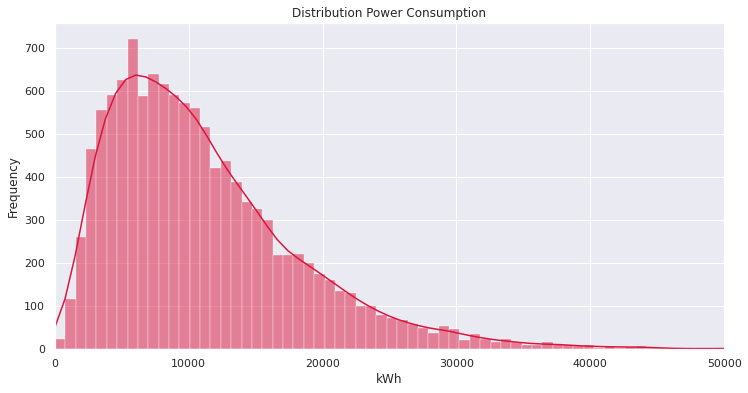

The mean of power consumption is 11288.15939750062 kWh
The standard deviation of power consumption is 7640.874642706363 kWh


In [ ]:
sns.set(style='darkgrid', palette=sns.diverging_palette(145, 400, s=20, l=30, 
                                                        n=8))
fig, ax = plt.subplots(figsize=(12, 6))
sns.histplot(data['KWH'], ax=ax, color='crimson', kde=True)
plt.xlim(0, 50000)
plt.title('Distribution Power Consumption')
plt.xlabel('kWh'), plt.ylabel('Frequency')
plt.show()
print('The mean of power consumption is {} kWh'.format(np.mean(data['KWH'])))
print('The standard deviation of power consumption is {} kWh'.format(np.std(
    data['KWH'])))

We can see that the distribution of power consumption has a positive skew. 

In [ ]:
from scipy.stats import skew

print('The skewness of power consumption is', skew(data['KWH']))

The skewness of power consumption is 2.1139253118494183


We will impose a log transformation to get something more like a normal distribution. Rather than trying to predict power consumption directly, we will instead try to predict its log transform.



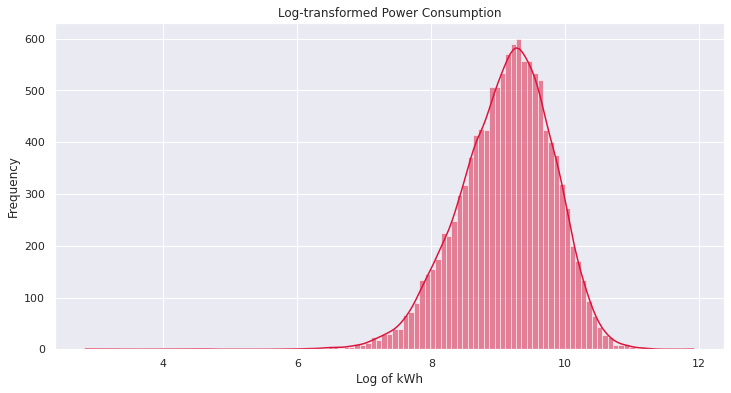

The mean of log-transformed power consumption is 9.112324123933075
The standard deviation of log-transformed power consumption is 0.6972040327782043
The skewness of log-transformed power consumption is -0.5643621254351062


In [ ]:
# Apply log to power consumption
kwh_log = np.log(data['KWH'])
_, ax = plt.subplots(figsize=(12, 6))
sns.histplot(kwh_log, ax=ax, color='crimson', kde=True)
plt.title('Log-transformed Power Consumption')
plt.xlabel('Log of kWh'), plt.ylabel('Frequency')
plt.show()
print('The mean of log-transformed power consumption is', np.mean(kwh_log))
print('The standard deviation of log-transformed power consumption is', np.std(
        kwh_log))
print('The skewness of log-transformed power consumption is', skew(kwh_log))

Next let's get an idea of how many outliers there are in the data. 

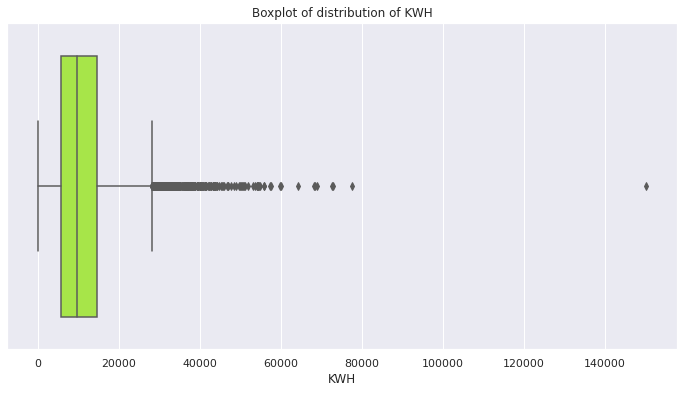

In [ ]:
_, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(x=data['KWH'], ax=ax, color='greenyellow')
plt.title('Boxplot of distribution of KWH')
plt.show()

I am a bit concerned about the number of outliers the boxplot revealed. I'll come back to that shortly.

Now that we have decided to work with log-transformed power consumption as our dependent variable, we should likewise impose a log transformation on the independent quantitative variables that can reasonably be guessed to be linearly related to power consumption. I identified the variables TOTSQFT, TOTSQFT_EN, TOTCSQFT, TOTHSQFT and MONEYPY as such (MONEYPY stands for household income whereas the others for various square footages).

In [ ]:
make_log = ['TOTSQFT', 'TOTCSQFT', 'TOTSQFT_EN', 'TOTHSQFT', 'MONEYPY']

for col in make_log:
  if np.min(new_data[col]) > 0: # need offset to avoid log(0)
    offset = 0
  else:
    offset = 1
  new_data[col] = np.log(new_data[col] + offset)

## **B. Creating training, validation and test data**

Next let's split the data into a training, a validation and a test set. I decided to go for a 0.5-0.25-0.25 split.

In [ ]:
from sklearn.model_selection import train_test_split

train_samples, other_samples, train_target, other_target = train_test_split(
    new_data, kwh_log, test_size=0.5, random_state=1)
val_samples, test_samples, val_target, test_target = train_test_split(
    other_samples, other_target, test_size=0.5, random_state=1)

As noted before, there are quite a few outliers for power consumption. The presence of many outliers in the training data can easily lead to overfitting. I therefore prefer to try to remove them from the training data, using a threshold of say 3 on zscore. (Note that I'm not removing outliers from the validation or test data.)


In [ ]:
from scipy import stats

train_samples = train_samples[(np.abs(stats.zscore(train_target)) < 3)]
train_target = train_target[(np.abs(stats.zscore(train_target)) < 3)]

## **C. Feature selection**

Now let's try to select the final features we will use in our predictive models. We create copies of our samples to test the effectiveness of these features.

In [ ]:
from copy import deepcopy

train_samples_og = deepcopy(train_samples)
val_samples_og = deepcopy(val_samples)
test_samples_og = deepcopy(test_samples)

### **Correlation with dependent variable**

Let's see how the independent variables we have kept so far are correlated with power consumption. We will discard those with absolute correlation coefficients below a cutoff yet to be decided. We only consider complete cases, meaning that for each variable we remove any sample containing an N/A value before calculating the (Pearson) correlation coefficient with power consumption.

In [ ]:
# Get correlations with power consumption considering only complete cases

corrs = pd.DataFrame(columns=['Log of KWH'])

for col in train_samples.columns:
  if '_DUM' in col:
    continue
  df = train_samples[col].to_frame()
  df['Log of KWH'] = kwh_log
  df = df[~df.eq(-2).any(1)] # discard incomplete cases
  corr = df.corr()['Log of KWH'].to_frame()['Log of KWH'][0]
  corrs.loc[col] = corr

corrs.sort_values(by='Log of KWH', ascending=False, inplace=True)
corrs

,Log of KWH
TOTROOMS,0.473815
BEDROOMS,0.461193
TOTSQFT,0.448283
TOTSQFT_EN,0.443137
HEATROOM,0.437397
...,...
DRYRUSE,-0.091117
WSF,-0.167875
PERIODNG,-0.201546
KOWNRENT,-0.306352


We don't see a strong correlation with power consumption for any one variable. Hopefully the combined effect of many weak to moderate correlations will be enough to get a good predictive model. It's useful to look at a heatmap of the absolute values of the correlation coefficients to get an idea where the cutoff should be.

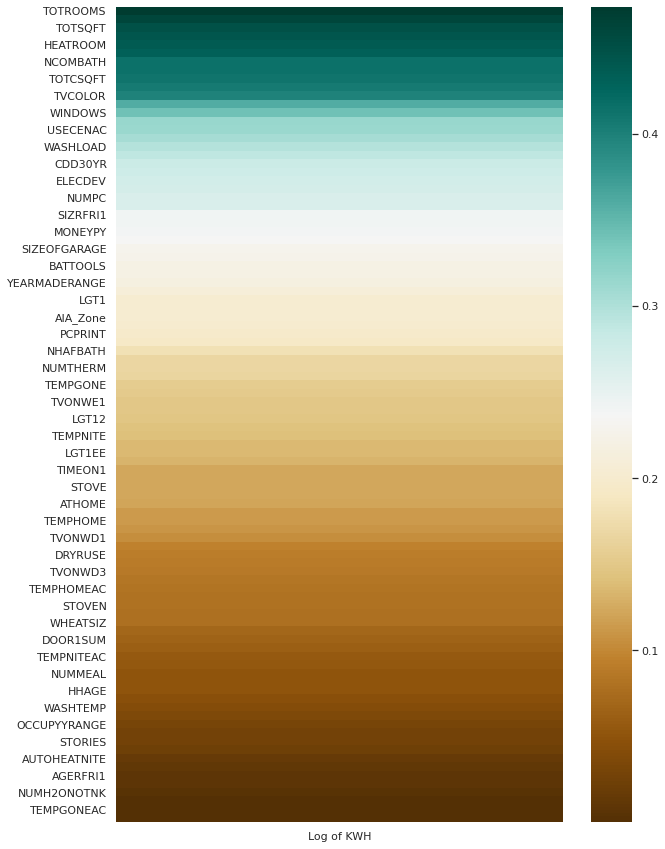

In [ ]:
_, ax = plt.subplots(figsize=(10, 15))
sns.heatmap(data=corrs.abs().sort_values(by='Log of KWH', ascending=False), 
            cmap='BrBG')
plt.show()

Based on the heatmap, I decided to be conservative and set the cutoff to 0.2.

In [ ]:
remove_cols = [col for col in corrs.index if corrs.abs()['Log of KWH'][col] < 
               0.2]
remove_dums = [col for col in train_samples.columns if col[:-4] in remove_cols]

train_samples = train_samples.drop(labels=remove_cols + remove_dums, axis=1)
val_samples = val_samples.drop(labels=remove_cols + remove_dums, axis=1)
test_samples = test_samples.drop(labels=remove_cols + remove_dums, axis=1)

### **Removing redundant features**

It's possible there are strong collinearities among the variables we selected in the previous step. These can decrease the accuracy of some predictive models, so let's try to identify the fouling variables. Here again we only consider complete cases in the calculation of correlation coefficients.

In [ ]:
# Get corrolation matrix only considering complete cases
inner_corrs = pd.DataFrame(columns=[col for col in test_samples.columns if (
    '_DUM' not in col)])

for row in train_samples.columns:
  if '_DUM' in row:
    continue
  coeffs = []
  for col in train_samples.columns:
    if '_DUM' in col:
      continue
    df  = pd.DataFrame()
    df[col] = train_samples[col]
    df[row] = train_samples[row]
    df = df[~df.eq(-2).any(1)]
    corr = df[row].corr(df[col])
    coeffs.append(corr)
  inner_corrs.loc[row] = coeffs

Let's use a heatmap again.

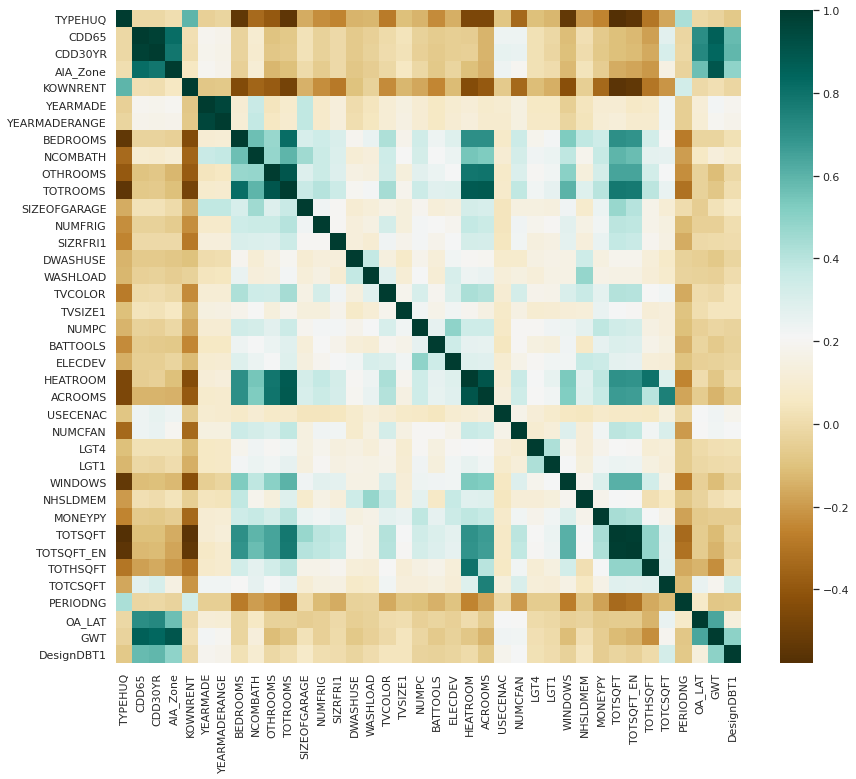

In [ ]:
fig, ax = plt.subplots(figsize=(14, 12))
sns.heatmap(inner_corrs, cmap='BrBG', ax=ax)
plt.show()

We can see a few strongly correlated variable pairs, most prominently


*   CDD65, GWT
*   CDD30YR, OA_LAT
*   YEARMADE, YEARMADERANGE
*   CDD30YR, GWT
*   AIA_Zone, GWT
*   CDD30YR, CDD65
*   CDD65, AIA_Zone 
*   BEDROOMS, TOTROOMS
*   HEATROOM, TOTROOMS
*   HEATROOM, TOTHSQFT
*   HEATROOM, ACROOMS
*   OTHROOMS, TOTROOMS
*   ACROOMS, USECENAC
*   TOTROOMS, TOTSQFT
*   TOTCSQFT, ACROOMS
*   TOTSQFT, TOTSQFT_EN
*   TOTSQFT, TOTHSQFT
*   TOTCSQFT, TOTHSQFT
*   TOTHSQFT, TOTSQFT_EN

After carefully looking again at the descriptions for these variables in the file 'public_layout.csv', I deemed that the most fundamental are GWT, CDD65, CDD30YR, AIA_Zone, YEARMADE, USECENAC, OA_LAT, TOTCSQFT, TOTSQFT and TOTHSQFT. Let's remove the other ones.





 

In [ ]:
remove_cols =  ['OTHROOMS', 'BEDROOMS', 'TOTSQFT_EN', 'HEATROOM', 'TOTROOMS',
              'ACROOMS', 'YEARMADERANGE']
remove_dums = [col for col in test_samples.columns if col[:-4] in remove_cols]

train_samples = train_samples.drop(labels=remove_cols + remove_dums, axis=1)
val_samples = val_samples.drop(labels=remove_cols + remove_dums, axis=1)
test_samples = test_samples.drop(labels=remove_cols + remove_dums, axis=1)

## **D. Model selection**

I'll now look at a few predictive models. I'll start with linear models then move to ensemble models.


### **Linear models**

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score

# build models
lin_model_1 = LinearRegression()
lin_model_2 = LinearRegression()

# train models
lin_model_1.fit(train_samples_og, train_target)
lin_model_2.fit(train_samples, train_target)

# test on validation data
pred_1 = lin_model_1.predict(val_samples_og)
pred_2 = lin_model_2.predict(val_samples)

# calculate losses
rmse_1 = mean_squared_error(val_target, pred_1, squared=False)
rmse_2 = mean_squared_error(val_target, pred_2, squared=False)
r2_1 = r2_score(val_target, pred_1)
r2_2 = r2_score(val_target, pred_2)

# creating a table to show losses
losses = pd.DataFrame(columns=['RMSE', 'R2'])
losses.loc['Linear Model 1'] = [rmse_1, r2_1]
losses.loc['Linear Model 2'] = [rmse_2, r2_2]
losses

,RMSE,R2
Linear Model 1,0.452358,0.583709
Linear Model 2,0.469260,0.552018


Not horrible, but not spectacular either. A bit surprisingly, we got a slightly worse fit on the dataset where we removed weak and redundant features than on the unaltered one. The coefficients of determination are in the moderate range and root mean square errors stand at around 65% of standard deviation. Let's see if ensemble models fare better.

### **Ensemble Methods**

In [ ]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# build models
rf_model_1 = RandomForestRegressor(random_state=1)
rf_model_2 = RandomForestRegressor(random_state=1)
gb_model_1 = GradientBoostingRegressor(random_state=1)
gb_model_2 = GradientBoostingRegressor(random_state=1)

# train models
rf_model_1.fit(train_samples_og, train_target)
rf_model_2.fit(train_samples, train_target)
gb_model_1.fit(train_samples_og, train_target)
gb_model_2.fit(train_samples, train_target)

# test on validation data
rf_pred_1 = rf_model_1.predict(val_samples_og)
rf_pred_2 = rf_model_2.predict(val_samples)
gb_pred_1 = gb_model_1.predict(val_samples_og)
gb_pred_2 = gb_model_2.predict(val_samples)

# calculate losses
rf_rmse_1 = mean_squared_error(val_target, rf_pred_1, squared=False)
rf_rmse_2 = mean_squared_error(val_target, rf_pred_2, squared=False)
rf_r2_1 = r2_score(val_target, rf_pred_1)
rf_r2_2 = r2_score(val_target, rf_pred_2)
gb_rmse_1 = mean_squared_error(val_target, gb_pred_1, squared=False)
gb_rmse_2 = mean_squared_error(val_target, gb_pred_2, squared=False)
gb_r2_1 = r2_score(val_target, gb_pred_1)
gb_r2_2 = r2_score(val_target, gb_pred_2)

# creating a table to show losses
losses = pd.DataFrame(columns=['RMSE', 'R2'])
losses.loc['Random Forest Model 1'] = [rf_rmse_1, rf_r2_1]
losses.loc['Random Forest Model 2'] = [rf_rmse_2, rf_r2_2]
losses.loc['Gradient Boosting Model 1'] = [gb_rmse_1, gb_r2_1]
losses.loc['Gradient Boosting Model 2'] = [gb_rmse_2, gb_r2_2]
losses

,RMSE,R2
Random Forest Model 1,0.449138,0.589614
Random Forest Model 2,0.459024,0.571349
Gradient Boosting Model 1,0.441084,0.604200
Gradient Boosting Model 2,0.455208,0.578447


Ok so we got the best results with gradient boosting trained on the unaltered dataset. Let's perform a grid search to try to improve the hyperparameters of this model.

In [ ]:
from sklearn.model_selection import GridSearchCV

# grid search
parameters = {'n_estimators': [100, 250, 500, 1000],
              'max_depth': [2, 3],
              'subsample': [0.6, 0.8, 1]}
gb_models = GradientBoostingRegressor(random_state=1)     
clf = GridSearchCV(gb_models, parameters)
clf.fit(train_samples_og, train_target)

# get losses on validation data
pred = clf.predict(val_samples_og)
rmse = mean_squared_error(val_target, pred, squared=False)
r2 = r2_score(val_target, pred)
losses = pd.DataFrame(columns=['RMSE', 'R2'])
losses.loc['Best gradient boosting'] = [rmse, r2]
losses

,RMSE,R2
Best gradient boosting,0.433615,0.61749


We managed to improve the model a bit.

## **E. Testing**

Finally, let's look at how the final model we selected performs on the test data if we have held out until now. Here we will use the original dependent variable KWH instead of its log transform.

In [ ]:
pred = np.exp(clf.predict(test_samples_og))
rmse = mean_squared_error(np.exp(test_target), pred, squared=False)
r2 = r2_score(np.exp(test_target), pred)
losses = pd.DataFrame(columns=['RMSE', 'R2'])
losses.loc['Best gradient boosting'] = [rmse, r2]
losses

,RMSE,R2
Best gradient boosting,4843.335964,0.559463


Not too bad. RMSE is still around 60-65% of standard deviation, and R2 is still in the moderate range. Let's try to get a better idea of where our model breaks down with plots.

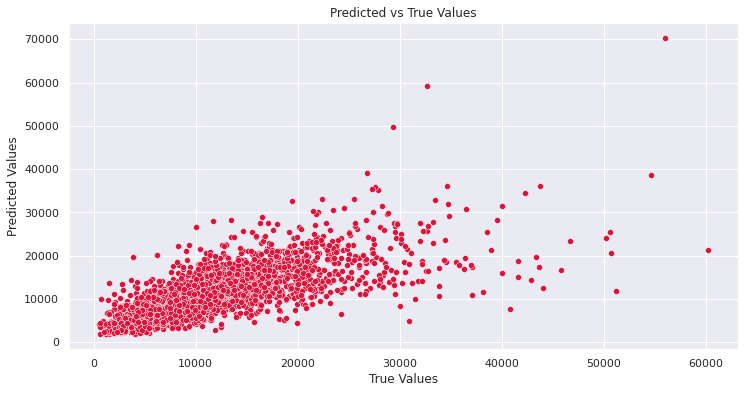

In [ ]:
# scatter plot
_, ax = plt.subplots(figsize=(12, 6))
sns.scatterplot(x=np.exp(test_target), y=pred, ax=ax, color='crimson')
plt.xlabel('True Values'), plt.ylabel('Predicted Values')
plt.title('Predicted vs True Values')
plt.show()

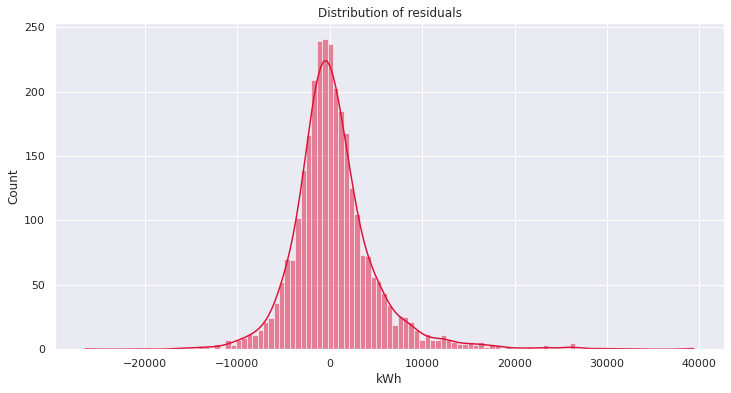

In [ ]:
# distribution of residuals
_, ax = plt.subplots(figsize=(12, 6))
sns.histplot(np.exp(test_target)-pred, ax=ax, color='crimson', kde=True)
plt.xlabel('kWh')
plt.title('Distribution of residuals')
plt.show()

The scatter plot shows that errors are generally larger right of the mean than left of it. This can also be seen in the milde positive skew the distribution of residuals shows.

# **4. Takeaway**

In the end we got an adequate model, though root mean square error was rather large relative to standard deviation and variance in the dependent variable could only be moderately predicted. I imagine the main limiting factor here is the lack of time granularity of the dataset: we are given aggregate year-wise data whereas the important factors influencing power consumption across different seasons and months of the year are surely different. Tellingly, the variables relating to temperature, heating and cooling are among the more strongly correlated with power consumption.